In [189]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
INPUT_DIM=28*28
HIDDEN_DIM=200
Z_DIM=20
BATCH_SIZE=32



class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super().__init__()

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.img_2_hid = nn.Linear(input_dim, hidden_dim)
        self.hid_2_mu = nn.Linear(hidden_dim, z_dim)
        self.hid_sigma = nn.Linear(hidden_dim, z_dim)

        self.z_2_hid = nn.Linear(z_dim, hidden_dim)
        self.hid_2_img = nn.Linear(hidden_dim, input_dim)

    def encoder(self, x):
        x = self.img_2_hid(x)
        x = self.relu(x)
        mu = self.hid_2_mu(x)
        sigma = self.hid_sigma(x)

        return mu, sigma
    
    def decoder(self, z):
        z = self.z_2_hid(z)
        x = self.hid_2_img(z)
        x = self.sigmoid(x)

        return x
    
    def sample_z(self, mu, sigma):
        z = mu + (sigma * torch.randn_like(sigma))

        return z
    
    def forward(self, x):
        mu, sigma = self.encoder(x)
        z = mu + (sigma * torch.randn_like(sigma))
        x = self.decoder(z)

        return x

In [119]:
# TRAINING

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Configuration
BATCH_SIZE = 32

# 1. Define Transforms
# transforms.ToTensor() does two important things:
#   a. Converts the image to a PyTorch Tensor.
#   b. Scales pixel values from [0, 255] down to [0.0, 1.0].
#      (This is crucial because your VAE Sigmoid output is also 0.0-1.0)
transform = transforms.ToTensor()

# 2. Download and Load Dataset
train_dataset = datasets.MNIST(
    root='./data',      # Folder where data will be stored
    train=True,         # We want the training set
    transform=transform,# Apply the transform defined above
    download=True       # Download from internet if not found in root
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

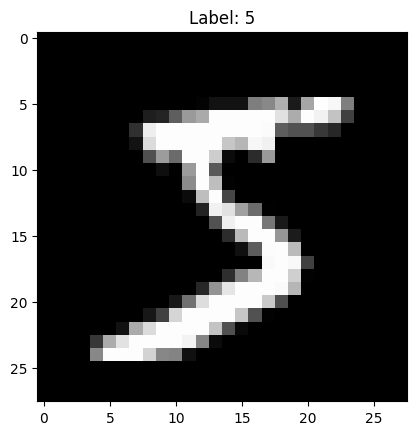

In [8]:
image, label = train_dataset[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'Label: {label}')
plt.show()

In [171]:
model = VariationalAutoEncoder()
optimiser = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [172]:
losses = []

for x, y in train_loader:
    x_flat = x.view(-1, 28*28)
    mu, sigma = model.encoder(x_flat)
    z = model.sample_z(mu, sigma)
    recons = model.decoder(z)
    bce_loss = - (x_flat * torch.log(recons) + (1-x_flat) * torch.log(1 - recons)).sum()
    kl_loss = 0.5 * (mu ** 2 + sigma ** 2 - torch.log(sigma **2) -1).sum()
    # kl_loss = 0
    loss = bce_loss + kl_loss
    
    optimiser.zero_grad(set_to_none=True)
    loss.backward()
    losses.append(loss.item())
    optimiser.step()


plt.plot(torch.tensor(losses).view(-1,100).mean(1))

RuntimeError: shape '[-1, 100]' is invalid for input of size 1875

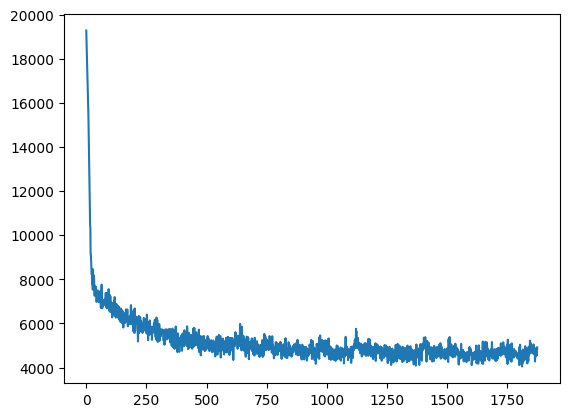

In [173]:
plt.plot(losses)

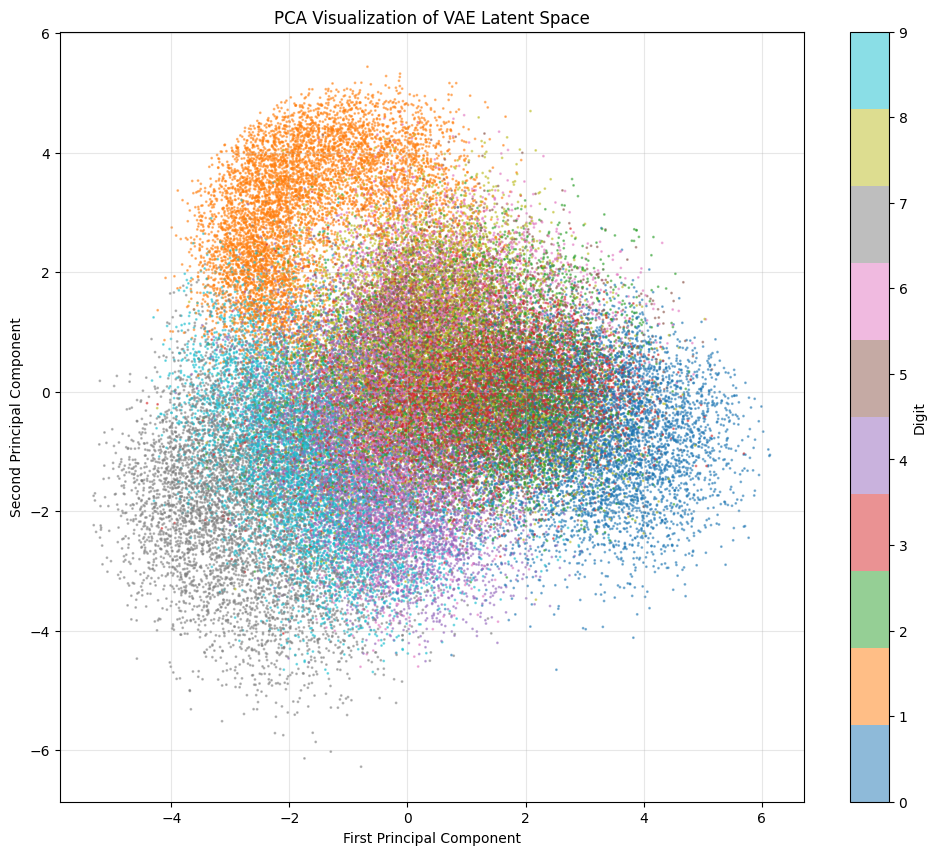

/var/folders/v5/z7rgl2ms317g49cj9p8qglrh0000gn/T/ipykernel_33834/2607468731.py:51: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1000 with 3 Axes> than <Figure size 1200x1000 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter, label='Digit')


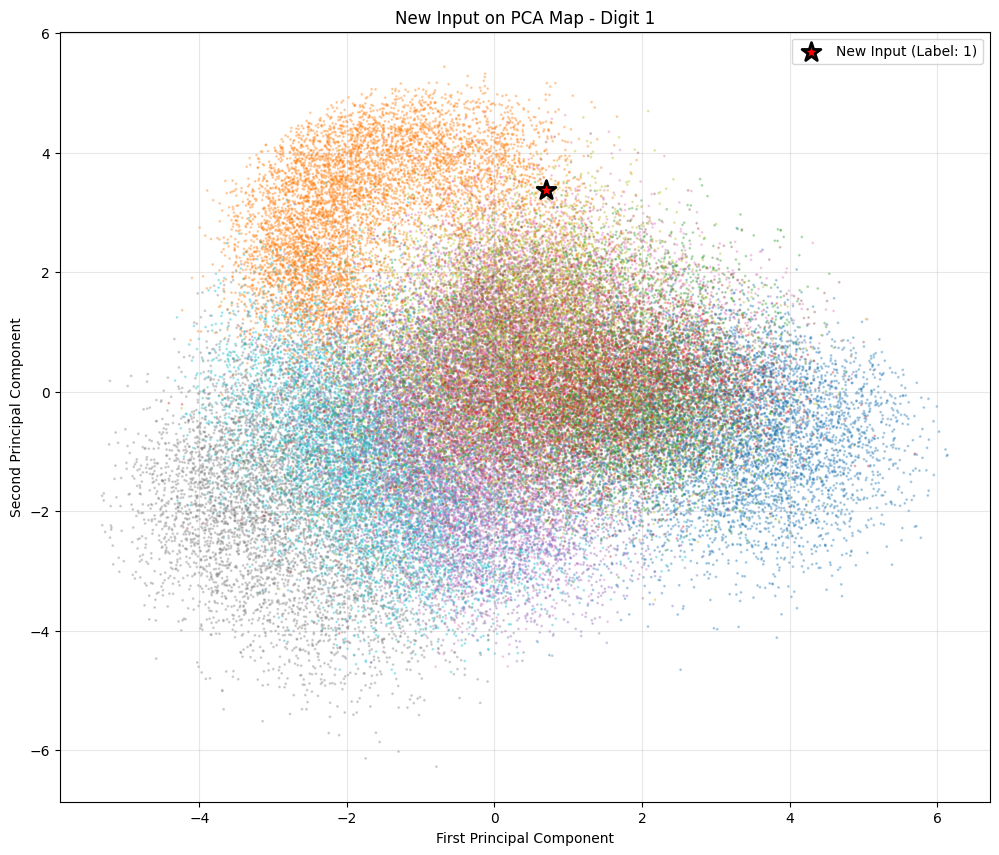

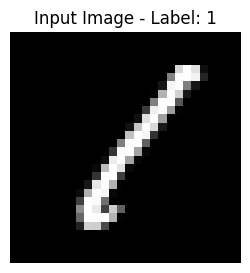

In [174]:
from sklearn.decomposition import PCA
import numpy as np

# Extract latent representations for all training images
model.eval()
latent_vectors = []
labels_list = []

with torch.no_grad():
    for img, lbl in train_dataset:
        img_flat = img.flatten().unsqueeze(0)
        mu, _ = model.encoder(img_flat)
        latent_vectors.append(mu.squeeze().numpy())
        labels_list.append(lbl)

latent_vectors = np.array(latent_vectors)
labels_list = np.array(labels_list)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)

# Plot the latent space
plt.figure(figsize=(12, 10))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels_list, cmap='tab10', alpha=0.5, s=1)
plt.colorbar(scatter, label='Digit')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Visualization of VAE Latent Space')
plt.grid(True, alpha=0.3)
plt.show()

# Function to plot a new input on the same map
def plot_new_input(image_index):
    """Plot a new input image on the PCA map"""
    img, lbl = train_dataset[image_index]
    
    with torch.no_grad():
        img_flat = img.flatten().unsqueeze(0)
        mu, _ = model.encoder(img_flat)
        new_latent = mu.squeeze().numpy()
    
    # Transform to PCA space
    new_latent_2d = pca.transform(new_latent.reshape(1, -1))
    
    # Plot with existing points
    plt.figure(figsize=(12, 10))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels_list, cmap='tab10', alpha=0.3, s=1)
    plt.scatter(new_latent_2d[0, 0], new_latent_2d[0, 1], c='red', s=200, marker='*', 
                edgecolors='black', linewidth=2, label=f'New Input (Label: {lbl})')
    plt.colorbar(scatter, label='Digit')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title(f'New Input on PCA Map - Digit {lbl}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Also show the input image
    plt.figure(figsize=(3, 3))
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f'Input Image - Label: {lbl}')
    plt.axis('off')
    plt.show()

# Example usage:
plot_new_input(637)

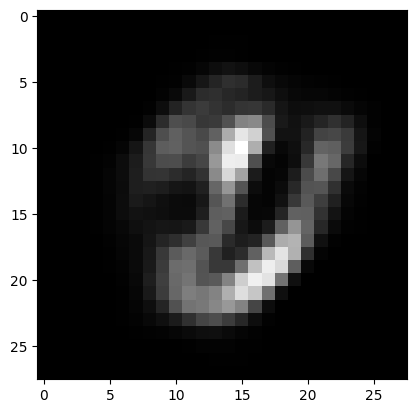

In [190]:
z = torch.randn(1, 20)
img = model.decoder(z)
plt.imshow(img.detach().view(28,28), cmap="gray")

In [191]:
with torch.no_grad():
    for img, lbl in train_dataset:
        img_flat = img.flatten().unsqueeze(0)
        mu, _ = model.encoder(img_flat)
        print(mu, _)
        break

tensor([[-0.2794, -1.7640, -0.3460,  0.5031,  1.2760, -1.4046, -0.1899, -0.3713,
          0.0494, -0.2915, -0.8093, -0.0473, -0.2612,  0.1324,  0.2426, -0.0890,
         -0.0549,  2.3722, -0.1041, -0.7828]]) tensor([[-0.1414,  0.3604,  0.1329,  0.6888, -0.2885,  0.4555, -0.2680, -0.5432,
         -0.4533, -1.7659,  0.2363, -0.3520, -0.3541,  0.9213, -0.3468, -0.3958,
          0.4098, -0.2306, -0.2838,  0.3169]])


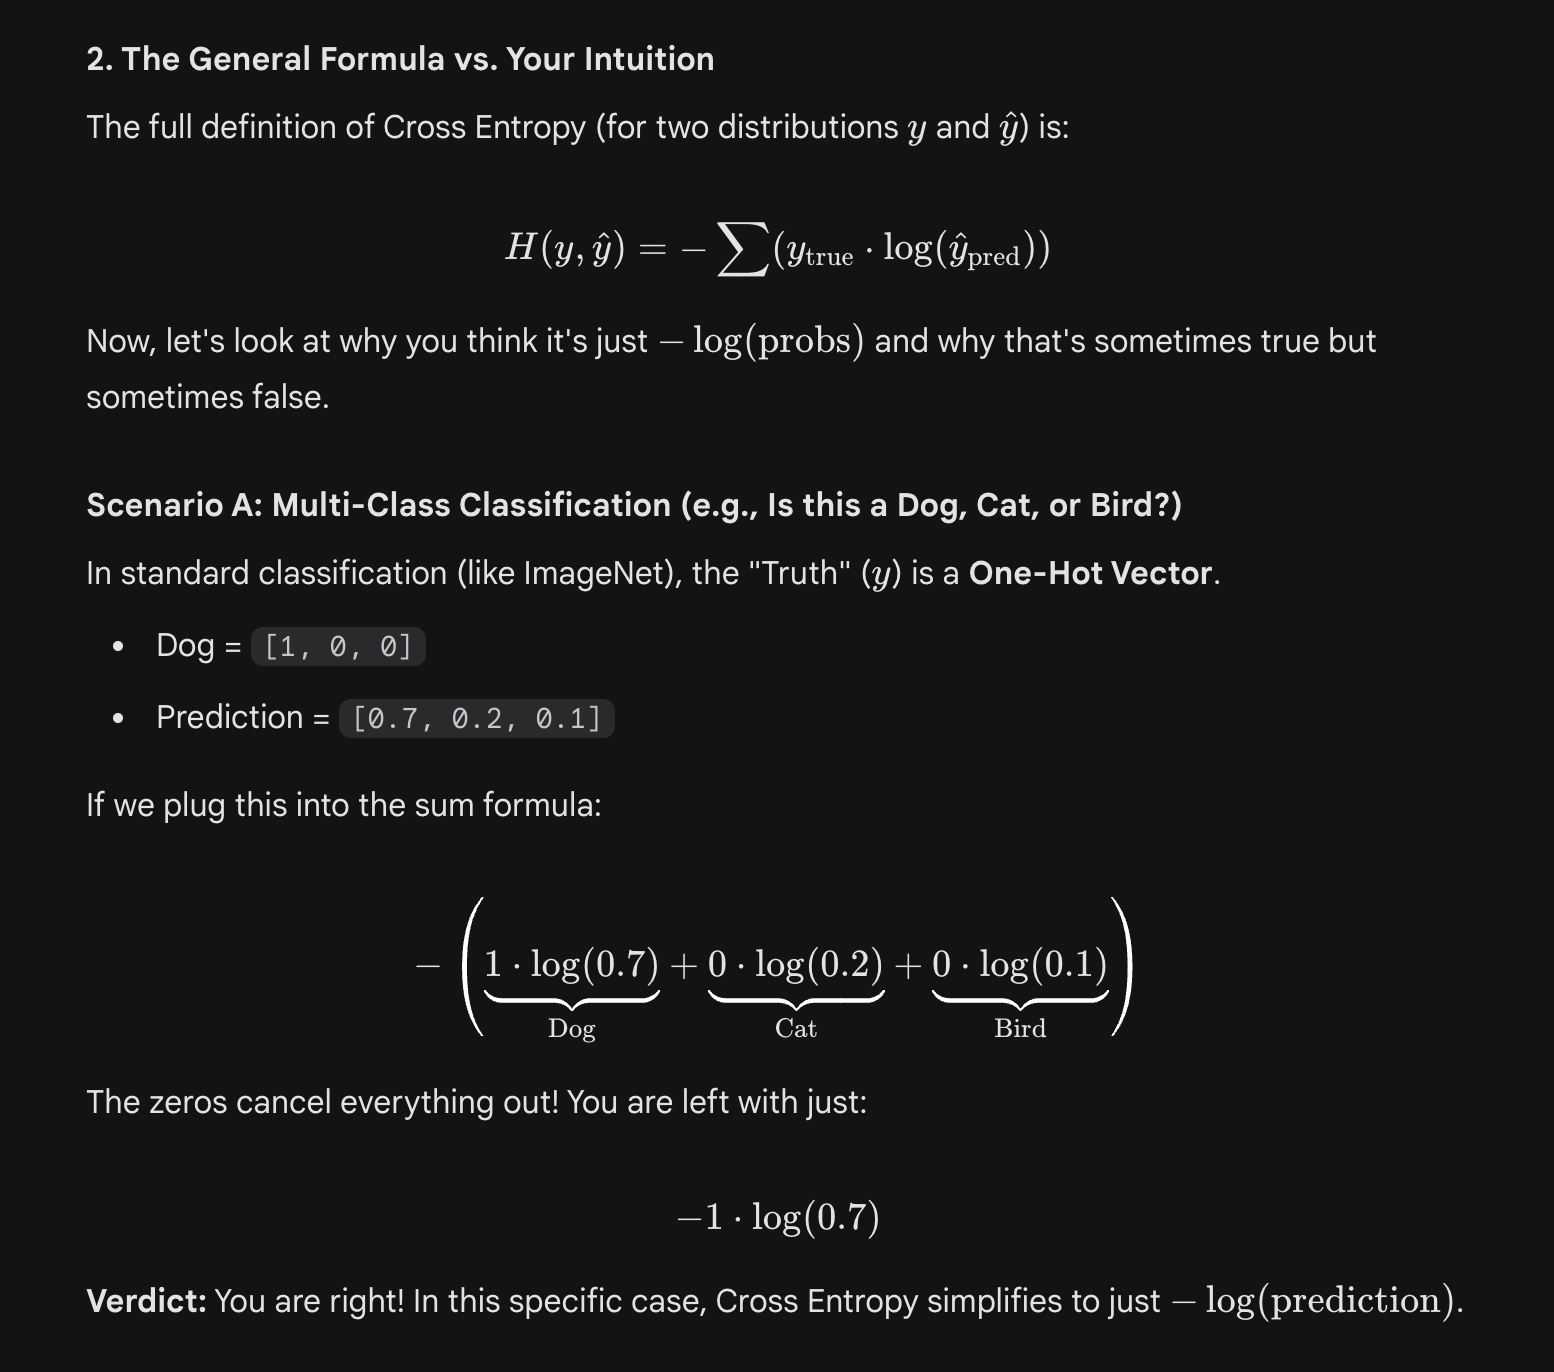
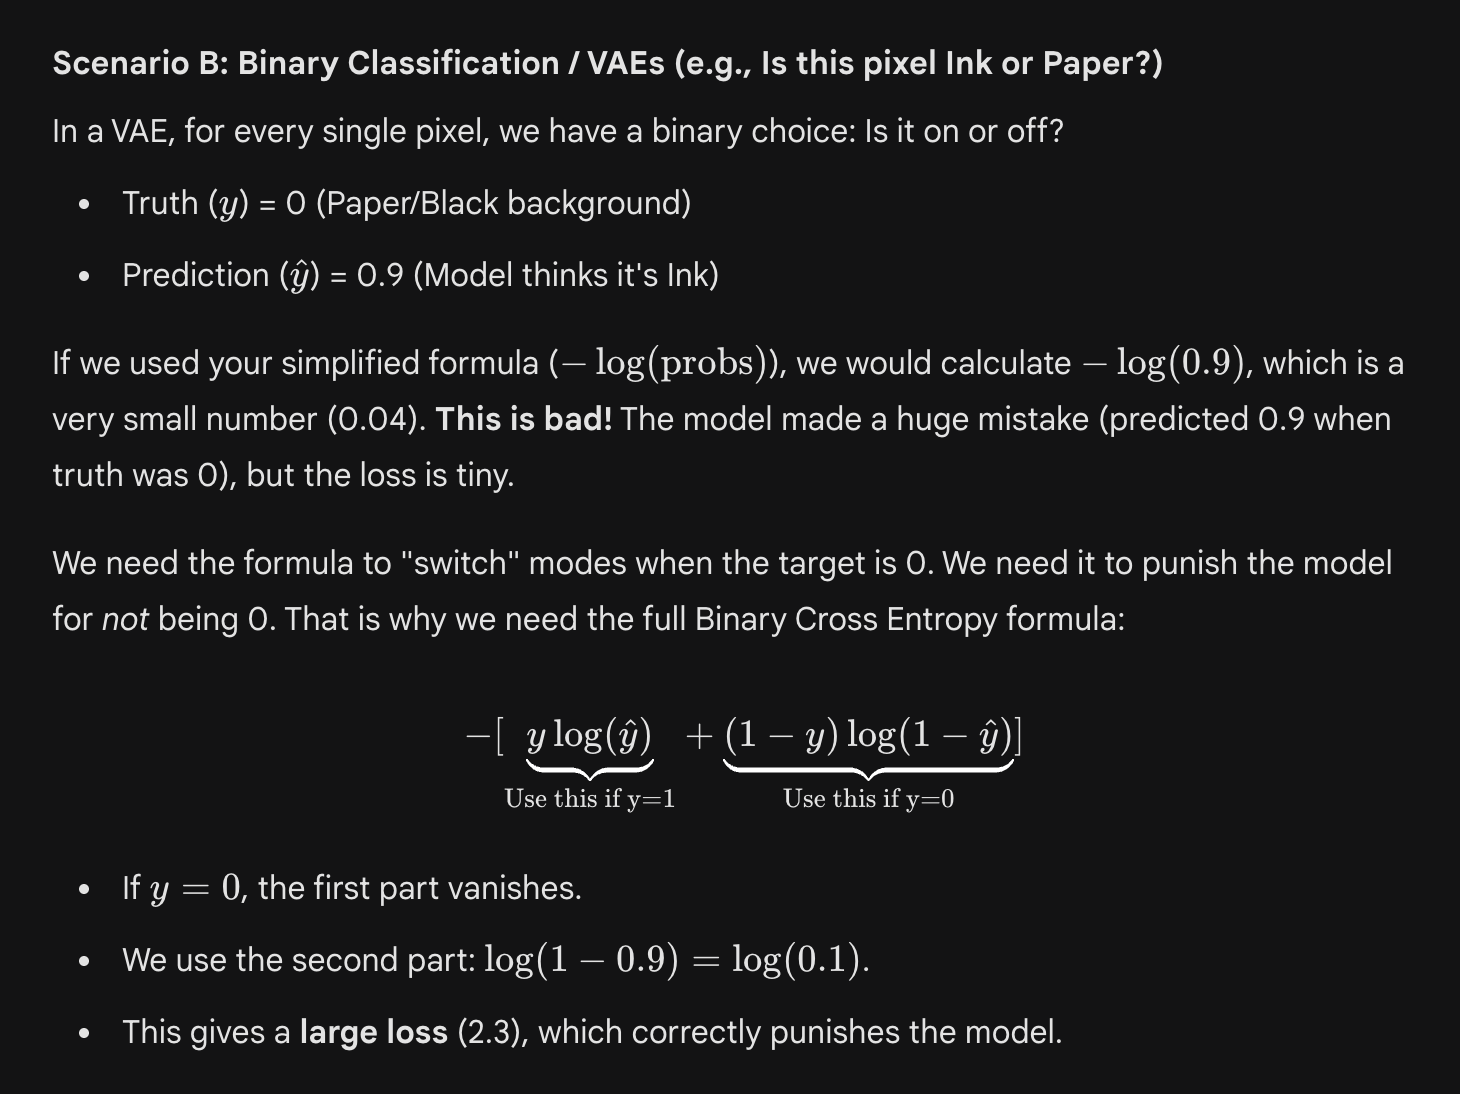